# EXAM - GROUP 5

## Data preparation

<Axes: xlabel='timestamp'>

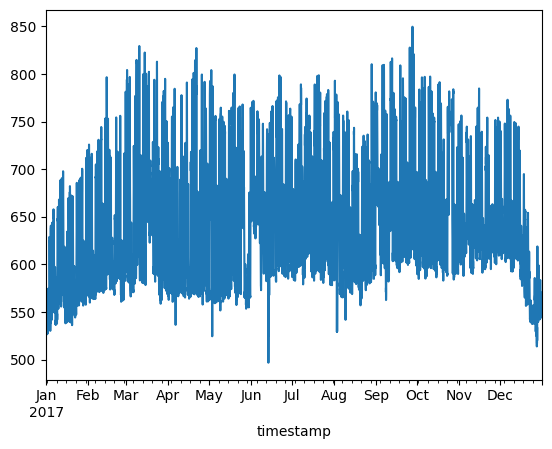

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import calmap
from matplotlib.colors import ListedColormap, Normalize

building_df_train = pd.read_csv("data/building_5_weather_1_train.csv", parse_dates=['timestamp'])
weather_df = pd.read_csv("data/weather_1.csv", parse_dates=['timestamp'])

building_df_test = pd.read_csv("data/building_5_weather_1_test.csv", parse_dates=['timestamp'])

building_df = pd.concat([building_df_test,building_df_train])

building_df.drop_duplicates(inplace=True)
building_df.set_index('timestamp',inplace=True)
weather_df.drop_duplicates(inplace=True)
weather_df.set_index('timestamp',inplace=True)

building_df.sort_index(inplace=True)

data = building_df.join(weather_df,how='left',on='timestamp') # we chose the left join because there are some missing dates in weather.csv

data['hour'] = data.index.hour
#data['date'] = data.index.map(lambda t:t.strftime('%Y-%m-%d'))
data['date'] = data.index.date
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month

data['power'].plot()



In [95]:
print(f'The dataset shape is:', data.shape)
print(f'The training dataset covers a period between', min(data.index), 'and', max(data.index))

The dataset shape is: (8760, 6)
The training dataset covers a period between 2017-01-01 00:00:00 and 2017-12-31 23:00:00


### Outliers

#### Z-score Outlier

timestamp
2017-03-10 14:00:00    829.4961
2017-09-27 14:00:00    849.7478
Name: power, dtype: float64


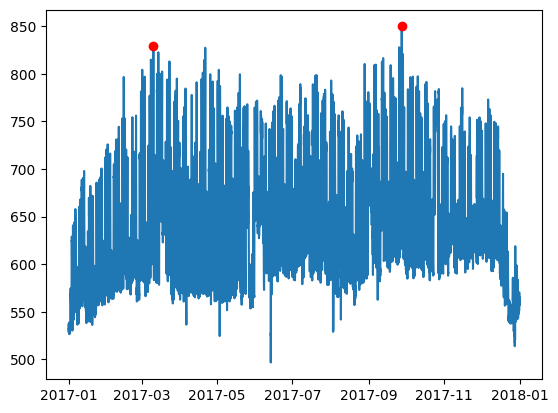

In [97]:
# calculate z-scores for each column
z_scores = (data['power'] - data['power'].mean()) / data['power'].std()

# define std limit (default 3)
std_limit = 3

# identify outliers as data points with z-score greater than std_limit or less than -std_limit
outliers_z_score = data['power'][(z_scores > std_limit) | (z_scores < -std_limit)]

print(outliers_z_score)

# plot column 'a' with outlier in red
plt.plot(data['power'])
plt.plot(outliers_z_score.index, data.loc[outliers_z_score.index, 'power'], 'ro')
plt.show()


#### Boxplot interquantile

timestamp
2017-03-10 14:00:00    829.4961
2017-03-14 14:00:00    822.6265
2017-04-21 14:00:00    827.3444
2017-09-25 14:00:00    827.8472
2017-09-26 14:00:00    819.3258
2017-09-27 14:00:00    849.7478
2017-09-27 15:00:00    828.7553
2017-09-28 13:00:00    818.0747
2017-09-28 14:00:00    820.8011
Name: power, dtype: float64


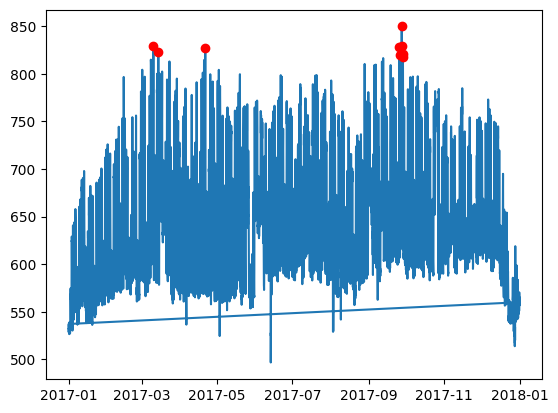

In [82]:
# evaluate 1st and 3rd quartile
Q1 = data['power'].quantile(0.25)
Q3 = data['power'].quantile(0.75)

# evaluate interquartile
IQR = Q3 - Q1

# define IQR limit (default 1.5)
IQR_limit = 1.5

# identify and highlight outliers
outliers_interquantile = data['power'][(data['power'] < Q1 - IQR_limit*IQR) | (data['power'] > Q3 + IQR_limit*IQR)]

print(outliers_interquantile)

plt.plot(data['power'])
plt.plot(outliers_interquantile.index, data.loc[outliers_interquantile.index, 'power'], 'ro')
plt.show()

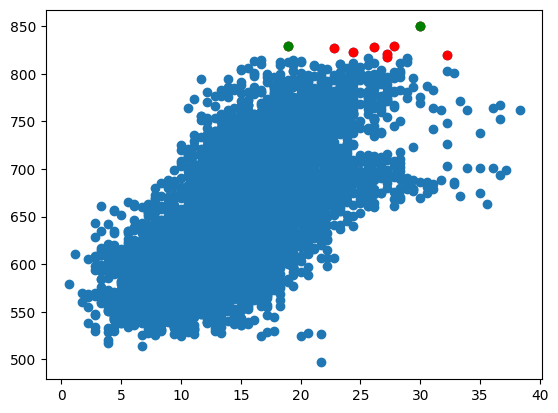

In [70]:
plt.scatter(data['airTemperature'],data['power'])
plt.scatter(data['airTemperature'].loc[outliers_interquantile.index],outliers_interquantile,c='red')
plt.scatter(data['airTemperature'].loc[outliers_z_score.index],outliers_z_score,c='green')
plt.show()

### Remove outliers

In [71]:
data.power.loc[outliers_z_score.index] = np.nan

data.head()

C:\Users\itsimic\AppData\Local\Temp\ipykernel_51232\2056532884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.power.loc[outliers_z_score.index] = np.nan


,power,airTemperature,hour,date,dayofweek,month
timestamp,,,,,,
2017-11-01 00:00:00,612.8761,10.6,0,2017-11-01,2,11
2017-11-01 01:00:00,613.1500,8.3,1,2017-11-01,2,11
2017-11-01 02:00:00,610.6006,8.9,2,2017-11-01,2,11
2017-11-01 03:00:00,609.1753,8.9,3,2017-11-01,2,11
2017-11-01 04:00:00,610.7250,8.3,4,2017-11-01,2,11


### Missing Value

In [72]:
print(f'The missing value for Power are:', data['power'].isna().sum())
print(f'The missing value for Temperature are:', data['airTemperature'].isna().sum())

The missing value for Power are: 42
The missing value for Temperature are: 1


<Axes: xlabel='timestamp'>

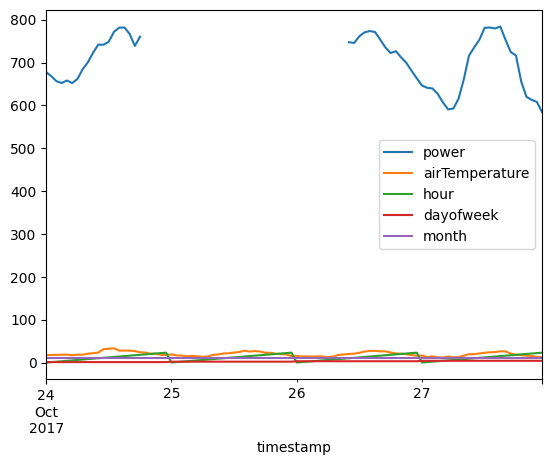

In [73]:
data[data['power'].isna()]
data["2017-10-24":"2017-10-27"].plot()

#### Interpolation with limit 3

In [74]:
data['airTemperature'].interpolate('spline',limit=3,inplace=True,order=3)

data['power'].interpolate('spline',limit=3,inplace=True,order=3)
data[data['power'].isna()]
data["2017-10-24":"2017-10-27"].plot()

ValueError: x must be increasing if s > 0

In [ ]:
print(f'The missing value for Power, after interpolation, are:', data['power'].isna().sum())
print(f'The missing value for Temperature, after interpolation, are:', data['airTemperature'].isna().sum())

The missing value for Power, after interpolation, are: 36
The missing value for Temperature, after interpolation, are: 0


In [ ]:
datesWithNa = np.unique(data.date[data['power'].isna()])
print(datesWithNa)

[datetime.date(2017, 10, 24) datetime.date(2017, 10, 25)
 datetime.date(2017, 10, 26)]


In [ ]:
# we drop the entire day if it has some NA

data_withoutNA = data[ ~data['date'].isin(datesWithNa)]
#data_withoutNA = data.dropna(subset=['power'])
print(data_withoutNA)

                        power  airTemperature  hour        date  dayofweek  \
timestamp                                                                    
2017-01-01 00:00:00  537.1756             8.3     0  2017-01-01          6   
2017-01-01 01:00:00  528.6003            10.6     1  2017-01-01          6   
2017-01-01 02:00:00  532.4253            11.1     2  2017-01-01          6   
2017-01-01 03:00:00  535.8997            11.1     3  2017-01-01          6   
2017-01-01 04:00:00  531.9250            10.6     4  2017-01-01          6   
...                       ...             ...   ...         ...        ...   
2017-10-31 19:00:00  657.7267            13.3    19  2017-10-31          1   
2017-10-31 20:00:00  655.2514            13.3    20  2017-10-31          1   
2017-10-31 21:00:00  635.5764            11.7    21  2017-10-31          1   
2017-10-31 22:00:00  632.8756            11.1    22  2017-10-31          1   
2017-10-31 23:00:00  615.5764            11.1    23  2017-10-31 

### Data visualization

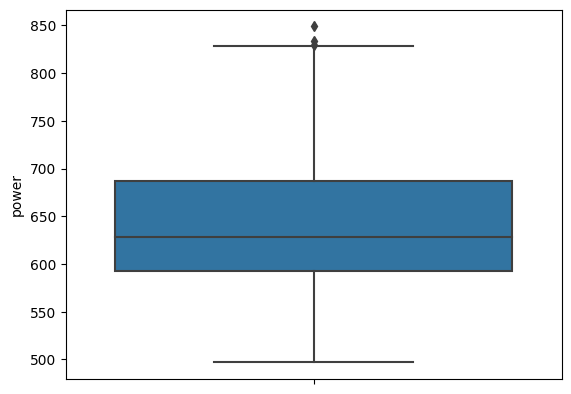

In [ ]:
sns.boxplot(y="power", data=data)
plt.show()

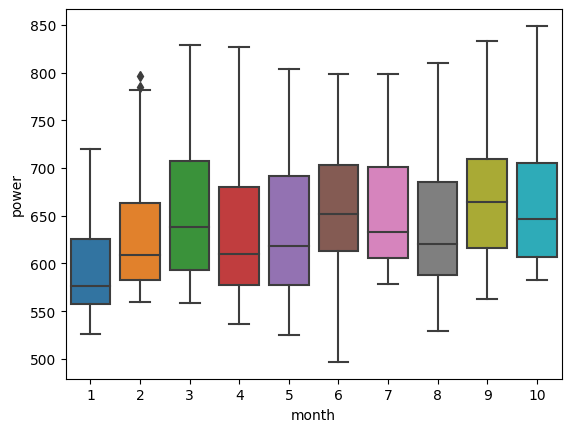

In [ ]:
sns.boxplot(x='month', y="power", data=data)
plt.show()

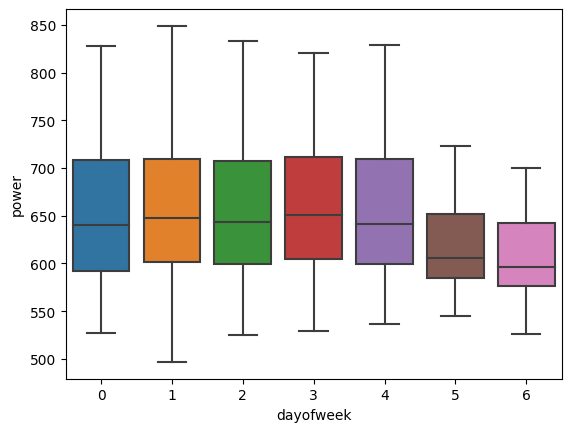

In [ ]:
sns.boxplot(x='dayofweek', y="power", data=data)
plt.show()

c:\Projects\dataScienceCourse-group5\.venv\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


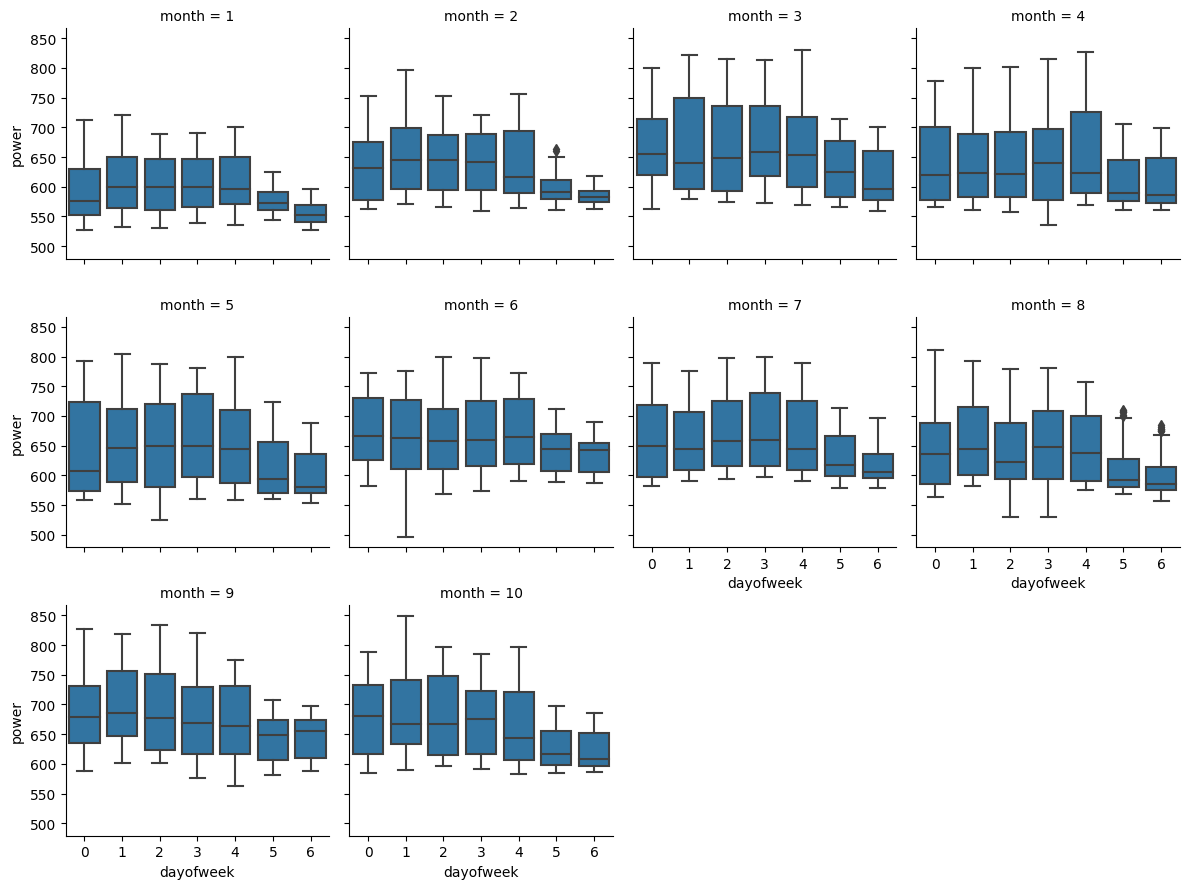

In [ ]:
g = sns.FacetGrid(data, col="month", col_wrap=4)
g.map(sns.boxplot, "dayofweek", "power")
plt.show()

##  Load profiles characterization

In [ ]:
print(f'The number of date duplicated is: ', data.index.duplicated().sum())

pv_data = data_withoutNA.pivot(index='date',columns='hour',values='power')

The number of date duplicated is:  0


Text(120.72222222222221, 0.5, 'Date')

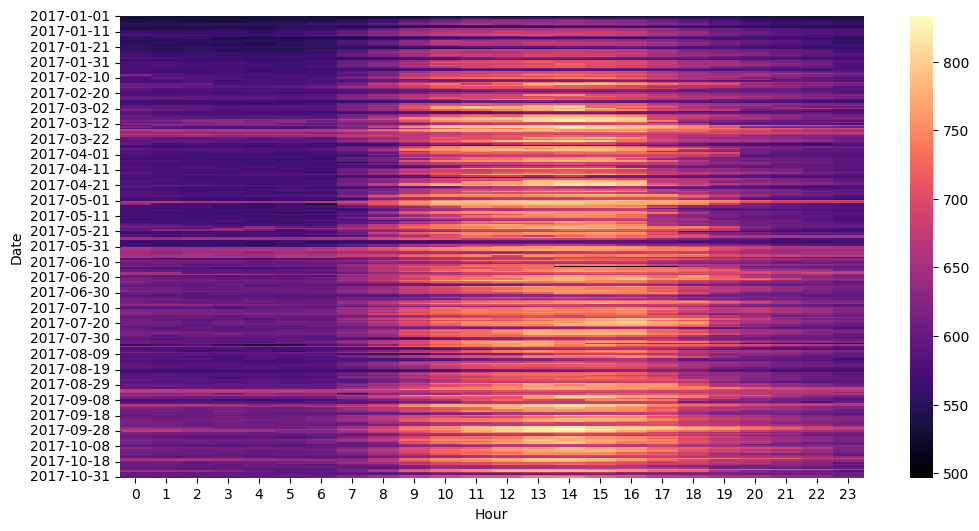

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(pv_data, cmap='magma', ax=ax)

# impostazione delle etichette degli assi
ax.set_xlabel('Hour')
ax.set_ylabel('Date')

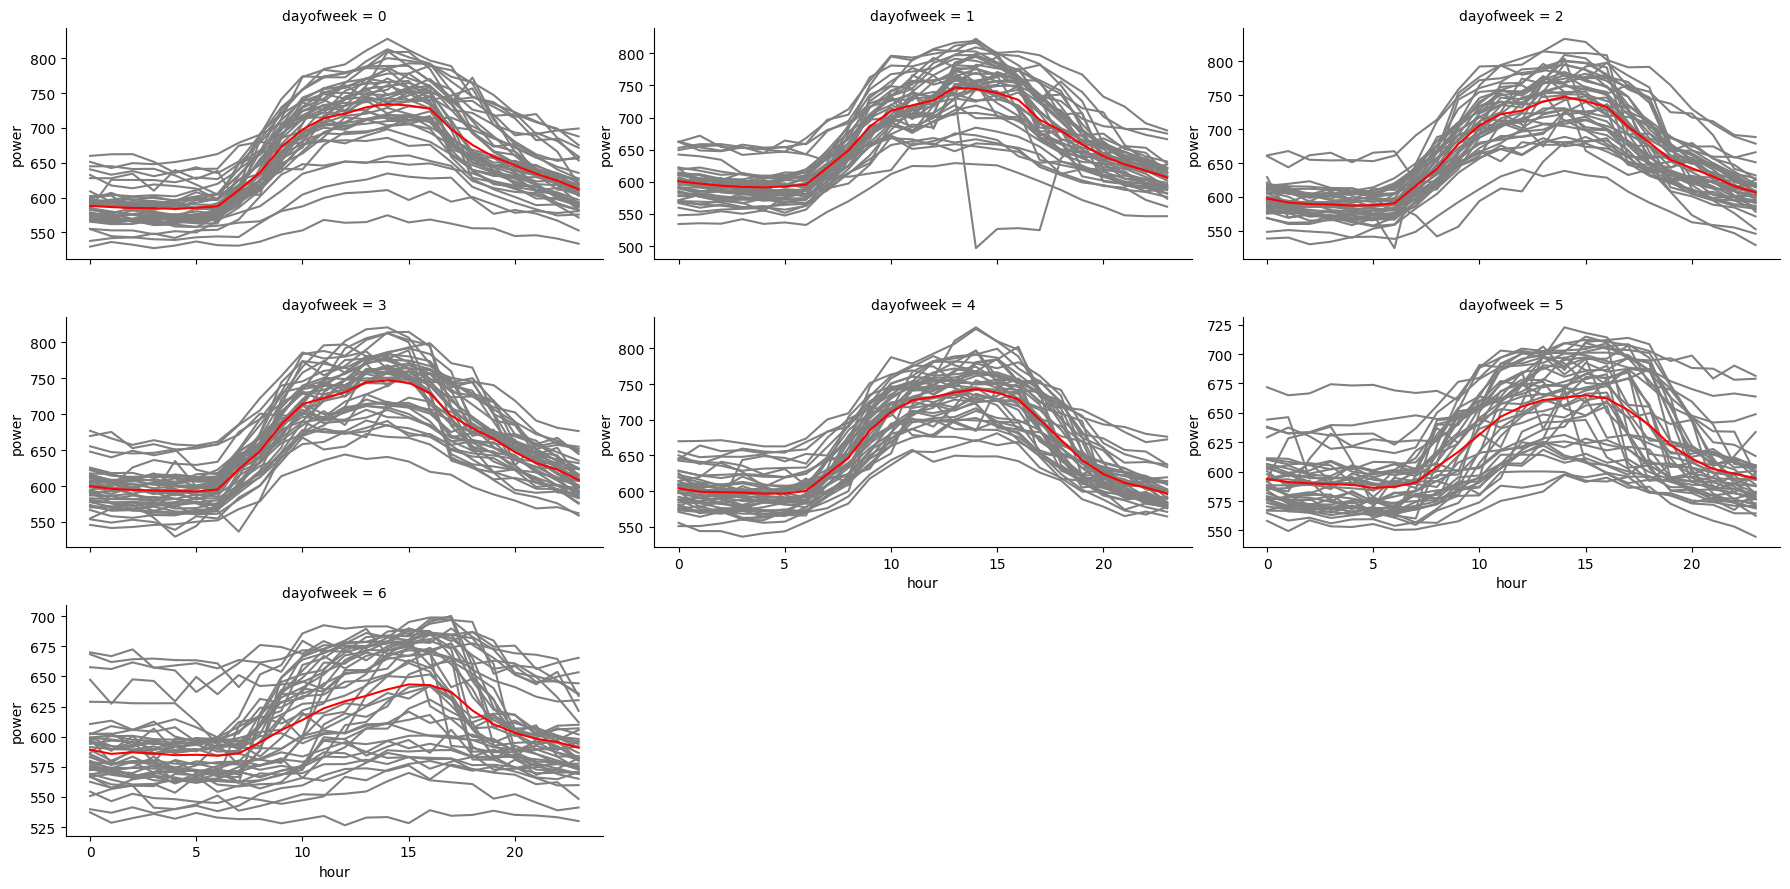

In [ ]:
# creating a new DataFrame with the average power for each hour of the day and for each day of the week
data_mean = data_withoutNA.groupby(['dayofweek', 'hour'])['power'].mean().reset_index()

# generating load profiles
g = sns.FacetGrid(data=data_withoutNA, col='dayofweek', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
for ax, day in zip(g.axes.flatten(), data_mean['dayofweek'].unique()):
    sns.lineplot(x='hour', y='power', data=data_mean[data_mean['dayofweek'] == day], color='r', ax=ax, label='Profilo medio', legend=False)

plt.show()

### Identification of the best cluster 
#### K-Means

In [ ]:
# pv_data.isna().sum()
# pv_data.dropna(inplace= True)

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

k_range = [i for i in range(2,8)]
db_list = []
sh_list = []

for k in k_range:
  kmeans = KMeans(n_clusters=k,random_state=0).fit(pv_data)
  labels = kmeans.labels_
  sh_list.append(silhouette_score(pv_data, labels))
  db_list.append(davies_bouldin_score(pv_data, labels))

print(f"The best number of clusters according to Silhouette is {k_range[np.argmax(sh_list)]} with a score of {round(max(sh_list),2)}")
print(f"The best number of clusters according to DB Index is {k_range[np.argmin(db_list)]} with a score fo {round(min(db_list),2)}")

c:\Projects\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Projects\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Projects\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Projects\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

The best number of clusters according to Silhouette is 2 with a score of 0.43
The best number of clusters according to DB Index is 2 with a score fo 0.83


c:\Projects\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
print(sh_list)
print(db_list)

[0.42519486098259246, 0.32044680708335593, 0.269948148528906, 0.278188418394559, 0.27227169409560115, 0.26359213148115407]
[0.8316864019372442, 1.0667571402000708, 1.1415308566042712, 1.1808536502050382, 1.1466533160108254, 1.19807879389286]


In [ ]:
# Both metrics indicate 2 as the best number of cluster
K = 2
kmeans = KMeans(n_clusters=K, n_init='auto', random_state=0).fit(pv_data)
labels = kmeans.labels_
cluster_counts = np.unique(labels, return_counts=True)
cluster_counts


(array([0, 1]), array([203,  98], dtype=int64))

C:\Users\itsimic\AppData\Local\Temp\ipykernel_51232\875680087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_withoutNA['cluster'] = np.repeat(labels, 24)
C:\Users\itsimic\AppData\Local\Temp\ipykernel_51232\875680087.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data_withoutNA.groupby(['cluster', 'hour']).mean().reset_index()


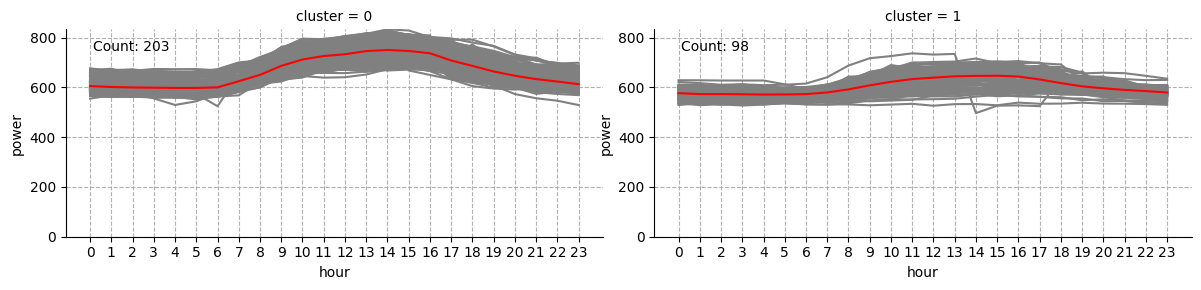

c:\Projects\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
c:\Projects\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]


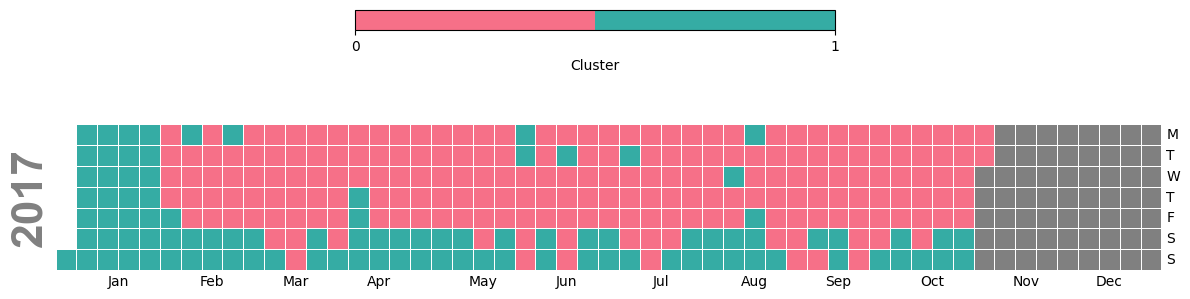

In [ ]:
data_withoutNA['cluster'] = np.repeat(labels, 24)

# creating a new DataFrame with the average power for each hour of the day and for each cluster
centroids = data_withoutNA.groupby(['cluster', 'hour']).mean().reset_index()
centroids.head()

# generating load profiles
g = sns.FacetGrid(data=data_withoutNA, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
i = 0
for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
    sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax, label='Profilo medio', legend=False)
    ax.set_ylim(bottom=0, top=data_withoutNA['power'].max())
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle='--')

    cluster_counts_str = 'Count: ' + str(cluster_counts[1][i])
    ax.text(0.05, 0.95, cluster_counts_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    i += 1

plt.show()


# CALENDAR VISUALIZATION
cal_data = pd.DataFrame({'cluster': labels}, index=pd.to_datetime(pv_data.index))

# define colors accordin to palette
colors = sns.color_palette("husl", K)
hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in colors]
cmap = ListedColormap(hex_colors)

fig, ax = calmap.calendarplot(cal_data['cluster'], cmap=cmap, 
                              fillcolor='grey', linewidth=0.5, fig_kws=dict(figsize=(12, 4)), monthticks=3, daylabels='MTWTFSS')

# add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=K-1))
sm.set_array([])
cax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
cb.set_label('Cluster')
cb.set_ticks(np.sort(cal_data['cluster'].unique()))
cb.set_ticklabels(np.sort(cal_data['cluster'].unique()))

plt.show()

C:\Users\itsimic\AppData\Local\Temp\ipykernel_51232\3181291154.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_withoutNA['cluster'] = np.repeat(labels, 24)
C:\Users\itsimic\AppData\Local\Temp\ipykernel_51232\3181291154.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = data_withoutNA.groupby(['cluster', 'hour']).mean().reset_index()


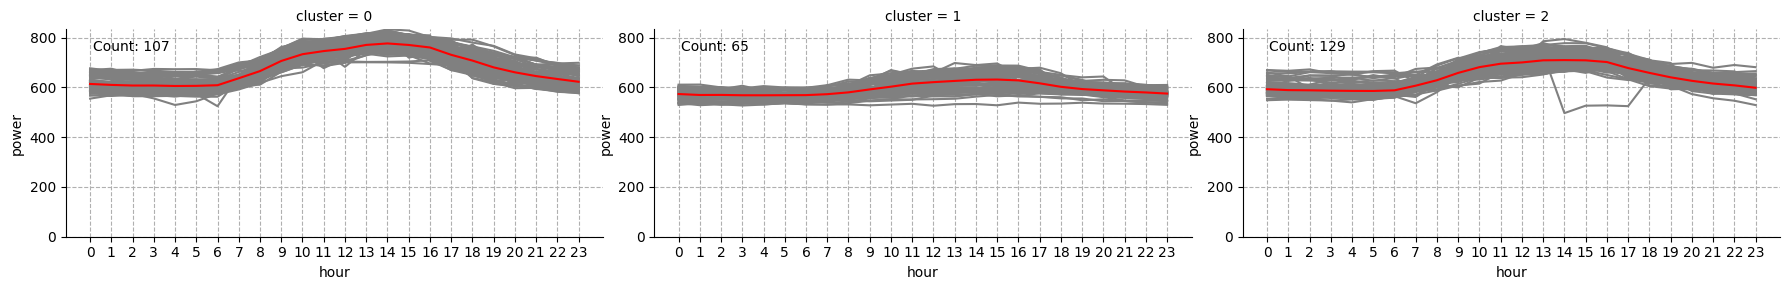

c:\Projects\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
c:\Projects\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]


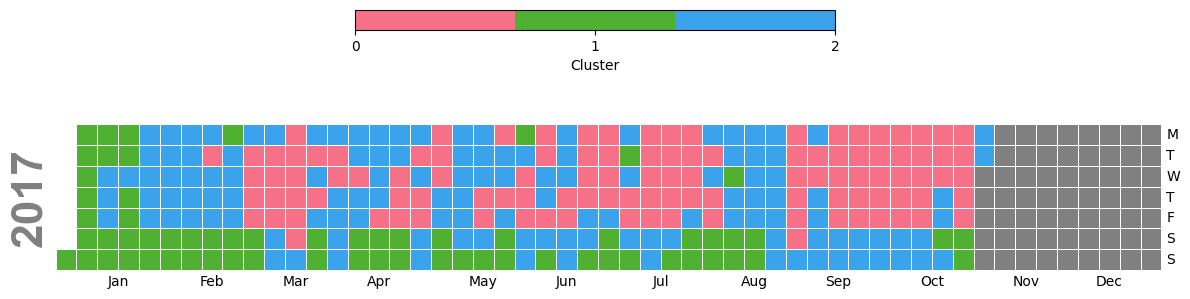

In [ ]:
#TRY 3 cluster
K = 3
kmeans = KMeans(n_clusters=K, n_init='auto', random_state=0).fit(pv_data)
labels = kmeans.labels_
cluster_counts = np.unique(labels, return_counts=True)
cluster_counts

data_withoutNA['cluster'] = np.repeat(labels, 24)

# creating a new DataFrame with the average power for each hour of the day and for each cluster
centroids = data_withoutNA.groupby(['cluster', 'hour']).mean().reset_index()
centroids.head()

# generating load profiles
g = sns.FacetGrid(data=data_withoutNA, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
i = 0
for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
    sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax, label='Profilo medio', legend=False)
    ax.set_ylim(bottom=0, top=data_withoutNA['power'].max())
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle='--')

    cluster_counts_str = 'Count: ' + str(cluster_counts[1][i])
    ax.text(0.05, 0.95, cluster_counts_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    i += 1

plt.show()


# CALENDAR VISUALIZATION
cal_data = pd.DataFrame({'cluster': labels}, index=pd.to_datetime(pv_data.index))

# define colors accordin to palette
colors = sns.color_palette("husl", K)
hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in colors]
cmap = ListedColormap(hex_colors)

fig, ax = calmap.calendarplot(cal_data['cluster'], cmap=cmap, 
                              fillcolor='grey', linewidth=0.5, fig_kws=dict(figsize=(12, 4)), monthticks=3, daylabels='MTWTFSS')

# add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=K-1))
sm.set_array([])
cax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
cb.set_label('Cluster')
cb.set_ticks(np.sort(cal_data['cluster'].unique()))
cb.set_ticklabels(np.sort(cal_data['cluster'].unique()))

plt.show()